# Implementation of the paper
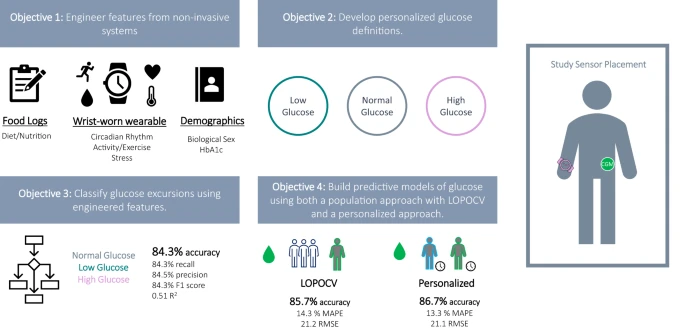

# Outlining the steps:
- Developing functions to develop features and saving those as .npy
- Devloping Personalised Definitions of Low, High and Normal glucose (LHN)
- Classification using SVM 
- Regression 

In [1]:
#Import the neccasary libraries
import os
import datetime
import glob
import IPython
import IPython.display
#import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns
import torch
from datetime import datetime, timedelta
from scipy.stats import skew, expectile
from scipy.signal import find_peaks

import pyhrv
from pyhrv.time_domain import nn50
if torch.cuda.is_available():
    print("Available GPU: ",torch.cuda.get_device_name(0))
else:
    print("Torch cannot find GPU")      


Available GPU:  NVIDIA A100-PCIE-40GB MIG 1g.5gb


In [7]:
historical_average = pd.DataFrame(columns=['HR_Mean', 'HR_Std', 'ACC_Mean', 'ACC_Std'])

# Getting the feature definitions:
https://static-content.springer.com/esm/art%3A10.1038%2Fs41746-021-00465-w/MediaObjects/41746_2021_465_MOESM1_ESM.pdf

| Feature Name | Feature Type         | Source         | Calculation/Description                                      |
|--------------|----------------------|----------------|-------------------------------------------------------------|
| Demographics| User-defined         | N/A            | N/A                                                         |
| User defined| N/A                  | N/A            | N/A                                                         |
| HbA1c       | Clinical Metrics     | Clincal   | N/A                                                         |
| EDA_Mean    | Electrodermal Activity | Stress      | μ = Σ xi / N                                                |
| EDA_Std     | Electrodermal Activity | Stress      | σ = √Σ(xi - μ)^2 / N                                         |
| EDA_Min     | Electrodermal Activity | Stress      | Nmin(xi) = minimum value of xi within N interval           |
| EDA_Max     | Electrodermal Activity | Stress      | Nmax(xi) = maximum value of xi within N interval           |
| EDA_Q1G     | Electrodermal Activity | Stress     | First quartile of xi values within N interval              |
| EDA_Q3G     | Electrodermal Activity | Stress      | Third quartile of xi values within N interval              |
| EDA_Skew    | Electrodermal Activity | Stress      | Skewness of xi values $\text{Skewness} = \frac{\sum_{i=n}^{i} (X_{i}-\mu)^3}{(N-1)*(\sigma)^3}$ within N interval                     |
| HR_Mean      | Heart Rate        | Wearable       | μ = Σ xi / N                                                |
| HR_Std       | Heart Rate        | Wearable       | σ = √Σ(xi - μ)^2 / N                                         |
| HR_Min       | Heart Rate        | Wearable       | Nmin(xi) = minimum value of xi within N interval           |
| HR_Max       | Heart Rate        | Wearable       | Nmax(xi) = maximum value of xi within N interval           |
| HR_Q1G       | Heart Rate        | Wearable       | First quartile of xi values within N interval              |
| HR_Q3G       | Heart Rate        | Wearable       | Third quartile of xi values within N interval              |
| HR_Skew      | Heart Rate        | Wearable       | Skewness of xi values within N interval                     |
| T_Mean      | Temperature       | Wearable       | μ = Σ xi / N                                                |
| T_Std       | Temperature        | Wearable       | σ = √Σ(xi - μ)^2 / N                                         |
| T_Min       | Temperature        | Wearable       | Nmin(xi) = minimum value of xi within N interval           |
| T_Max       | Temperature       | Wearable       | Nmax(xi) = maximum value of xi within N interval           |
| T_Q1G       | Temperature         | Wearable       | First quartile of xi values within N interval              |
| T_Q3G       | Temperature         | Wearable       | Third quartile of xi values within N interval              |
| T_Skew      | Temperature         | Wearable       | Skewness of xi values within N interval                     |
| ACC_Mean     | Accelerometry     | Wearable       | μ = Σ xi / N                                                |
| ACC_Std      | Accelerometry     | Wearable       | σ = √Σ(xi - μ)^2 / N                                         |
| ACC_Min      | Accelerometry     | Wearable       | Nmin(xi) = minimum value of xi within N interval           |
| ACC_Max      | Accelerometry     | Wearable       | Nmax(xi) = maximum value of xi within N interval           |
| ACC_Q1G      | Accelerometry     | Wearable       | First quartile of xi values within N interval              |
| ACC_Q3G      | Accelerometry     | Wearable       | Third quartile of xi values within N interval              |
| ACC_Skew     | Accelerometry     | Wearable       | Skewness of xi values within N interval                     | 
| PeakEDA      | Stress            | Wearable       | $\sum {N_p}$ Peaks defined by rolling peak detection (height=0, distance=4, prominence=0.3) [Reference](https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data) ||
| PeakEDA2hr_sum | Stress           | Wearable       |$\sum {N_p}$ Peaks defined by rolling peak detection (height=0, distance=4, prominence=0.3) [Reference](https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data) | *rolling calculation*|
 | maxHRV       | Stress            | Wearable       | Maximum of IBI over the N interval                         |
 | minHRV       | Stress            | Wearable       | Minimum of IBI over the N interval                         |
| medianHRV    | Stress            | Wearable       | Median of IBI over the N interval                          |
| meanHRV      | Stress            | Wearable       | μ = Σ IBI / N               | SDNN         | Stress            | Wearable       | $\sqrt{\frac{\sum (IBI - \mu)^2}{N}}$                      |
 | NN50         | Stress            | Wearable       | $\sum \text{where } |IBI[i+1] - IBI[i]| > 50$                   |
| pNN50        | Stress            | Wearable       | $\frac{\text{count}(NN50)}{N}$                              |
| RMSSD        | Stress            | Wearable       | $\sqrt{\sum |IBI[i+1] - IBI[i]|^2 / N}$                     |
| calories2hr  | Diet Food Log     | Sum over 2 hours | $\sum \text{Calories}$ (rolling calculation)               |
| protein2hr   | Diet Food Log     | Sum over 2 hours | $\sum \text{Protein}$ (rolling calculation)                |
| carbs2hr     | Diet Food Log     | Sum over 2 hours | $\sum \text{Carbs}$ (rolling calculation)                  |
| sugar2hr     | Diet Food Log     | Sum over 2 hours | $\sum \text{Sugar}$ (rolling calculation)                  |
| calories8hr  | Diet Food Log     | Sum over 8 hours | $\sum \text{Calories}$ (rolling calculation)               |
| protein8hr   | Diet Food Log     | Sum over 8 hours | $\sum \text{Protein}$ (rolling calculation)                |
| carbs8hr     | Diet Food Log     | Sum over 8 hours | $\sum \text{Carbs}$ (rolling calculation)                  |
| sugar8hr     | Diet Food Log     | Sum over 8 hours | $\sum \text{Sugar}$ (rolling calculation)                  |
| calories24hr | Diet Food Log     | Sum over 24 hours| $\sum \text{Calories}$ (rolling calculation)               |
| protein24hr  | Diet Food Log     | Sum over 24 hours| $\sum \text{Protein}$ (rolling calculation)                |
| carbs24hr    | Diet Food Log     | Sum over 24 hours| $\sum \text{Carbs}$ (rolling calculation)                  |
| sugar24hr    | Diet Food Log     | Sum over 24 hours| $\sum \text{Sugar}$ (rolling calculation)                  |
| Eat          | Diet Food Log     | Binary          | 0 if not eating currently, 1 if currently eating          |
| Eatcnt2hr    | Diet Food Log | Sum over 2 hours | $\sum \text{Eat}$ (rolling calculation)                  |
| Eatcnt8hr    | Diet Food Log | Sum over 8 hours | $\sum \text{Eat}$ (rolling calculation)                  |
| Eatcnt24hr   | Diet Food Log | Sum over 24 hours| $\sum \text{Eat}$ (rolling calculation)                  |
| WakeTime     | Circadian Rhythm | Wearable | explained later |
| Minfrommid   | Circadian Rhythm | Wearable | Minutes from midnight                                       |
| Hourfrommid  | Circadian Rhythm | Wearable | Hours from midnight                                         |
| ACC_mean_2hrs | Activity/exercise | Wearable | $\sum \text{ACC Mean}$ (rolling calculation)              |
| ACC_max_2hrs | Activity/exercise | Wearable | Maximum of ACC values over a 2-hour rolling interval       |
| Activity_bouts | Activity/exercise | Wearable | Binary exercise point designated if both ACC_Mean and HR_Mean over N interval were greater than historical mean |
| Activity24   | Activity/exercise | Wearable | $\sum \text{Activity_bouts} / N_{24\text{hr}}$ (rolling calculation) |
| Activity1hr  | Activity/exercise | Wearable | $\sum \text{Activity\_bouts}$ (rolling calculation) over 1 hour interval |
| ID           | Personalization Model | Assigned ID | Assigned to designate different participants             |



Wake time: Circadian Rhythm 
1. One point assigned based on whether HR_Mean, HR_Std, ACC_Mean, and ACC_Std for each N interval are each less than historical average.
2. If points > 2, binary assignment of 1.
3. Data averaged over 3 hours using rolling approach.
4. Wake Time assigned when slope of data changed and remained consistently higher for 25 and 75 minutes after the designated Wake Time. 

# Here we make our new features
- Ultradian Cycles.  (David's book suggest 90/180 minute cycles, let us use that for now)
- Eating frequency. 
- Time of the day. 
- Dark/Light.
- Sleep from this paper: https://www.nature.com/articles/s41598-018-31266-z
- Accelerometer features by the paper shared by Brian.
- Interquarantile Range

In [8]:
#configs:
number_participants = 16
df_initial_times= pd.DataFrame(0,columns=['Participant','Start_Time','End_Time'],index=range(number_participants+1))
features=['Time','IG','Participant','HR_Mean','HR_Max','HR_Std','HR_Skew','HR_Q1G','HR_Q3G',
         'EDA_Mean','EDA_Max','EDA_Std','EDA_Skew','EDA_Q1G','EDA_Q3G',
         'TEMP_Mean','TEMP_Max','TEMP_Std','TEMP_Skew','TEMP_Q1G','TEMP_Q3G',
         'ACC_Mean','ACC_Max','ACC_Std','ACC_Skew','ACC_Q1G','ACC_Q3G',
         'BVP_Mean','BVP_Max','BVP_Std','BVP_Skew','BVP_Q1G','BVP_Q3G', 
         'Gender','HbA1c',
          'PeakEDA','PeakEDA_2hrsum','PeakEDA_2hrmean',
          'maxHRV','minHRV','medianHRV','meanHRV','SDNN','NN50','pNN50','RMSSD',
          'calories2hr','protien2hr','sugar2hr','carbs2hr',
          'calories8r','protien8hr','sugar8hr','carbs8hr',
          'calories24hr','protien24hr','sugar24hr','carbs24hr',
          'Eat','Eatcnt2hr','Eatcnt8hr','Eatcnt24hr','Eatmean2hr',
          'Eatmean8hr','Eatmean24hr',
          'WakeTime','Minfrommid','Hourfrommid'
         ]
number_of_glucose_readings=36856
df_features=pd.DataFrame(0,columns=features,index=range(number_of_glucose_readings+1))
path_to_demographics='big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.1/Demo.xlsx'
#demo_dict['Participant'] = {}


In [9]:

def handle_dexcom():
    current_index=0
    path_to_data='big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.1'
    total_readings=0
    for path in os.listdir(path_to_data):
        #print(path)
        
        if path.endswith(".xlsx") or path.endswith(".csv") or path.endswith(".txt"):
            #print(path)
            continue
        else:
            
            
            path_to_dexcom=os.path.join(path_to_data,path,"Dexcom_"+path+".csv")
            #print(path_to_dexcom)
            if not '.ipynb_checkpoints' in path_to_dexcom:
                read_file=pd.read_csv(path_to_dexcom,skiprows=14,usecols=[0,1,7],parse_dates=[1])
                df_initial_times['Participant'][int(path)]=path
                df_initial_times['Start_Time'][int(path)]=pd.to_datetime(read_file.iloc[1,1])
                df_initial_times['End_Time'][int(path)]=pd.to_datetime(read_file.iloc[-1,1])
            
                total_readings=total_readings+len(read_file)
                
                start=total_readings-len(read_file)
                end=total_readings
                df_features['Participant'][start:end]=path
                df_features['Time'][start:end]=pd.to_datetime(read_file.iloc[:,1])
                df_features['IG'][start:end]=read_file.iloc[:,2]
           
                
            
            #print(read_file.iloc[1,1])

                      
                                        
            continue
        #df_features.set_index('Time')
        return
            
            #print(path_to_dexcom)
           
        
        
  

In [18]:
def sensor_statistical_features(sensor='EDA', df_features1=df_features, participant_number=2):
    """
    Creates feature in the format Sensor_Mean
    """
    #print('here')
    if sensor=='HR' and participant_number==1:
        print('I')
        return
    
   

    if participant_number < 10:
        parti = '00' + str(participant_number)
    else:
        parti = '0' + str(participant_number)

    # read the path_to_participant
    path_to_participant='big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.1/'+parti
    path_to_file = os.path.join(path_to_participant, sensor + '_' + parti + '.csv')
    participant_initial_time = df_initial_times.loc[[participant_number]]['Start_Time']
    participant_end_time =df_initial_times.loc[[participant_number]]['End_Time']
    file_read = pd.read_csv(path_to_file, parse_dates=['datetime'])
    file_read['datetime'] = pd.to_datetime(file_read['datetime'], format='%Y-%m-%d %H:%M:%S.%f')
    file_read = file_read.sort_values(by='datetime')
    #print(path_to_file)
    if sensor=='ACC':
        file_column_name=sensor
    else:
        file_column_name=' '+sensor.lower()
        
         
    
    
    
    
    # Set the DataFrame index to the 'datetime' column
    file_read.set_index('datetime', inplace=True)
    file_read = file_read.sort_values(by='datetime')
    file_read.truncate(before=participant_initial_time[participant_number])
    file_read.truncate(after=participant_end_time[participant_number])
    ite=0
    22
    #print('here')
    interval = pd.Timedelta(minutes=5)


    for index,row in df_features[df_features['Participant']==parti].iterrows():
        ite=ite+1
        #print(index)
        if ite> len(df_features[df_features['Participant']==parti]):
            continue
        
            
        first_time = row['Time']
        #print(first_time)
        second_time = first_time+interval
        #print(second_time)
        if file_read[first_time:second_time][file_column_name].empty:
            df_features.loc[[index,'Participant'==parti],sensor+'_Mean']=np.nan
            df_features.loc[[index,'Participant'==parti],sensor+'_Max']=np.nan                
            df_features.loc[[index,'Participant'==parti],sensor+'_Min']=np.nan
            df_features.loc[[index,'Participant'==parti],sensor+'_Q1G']=np.nan
            df_features.loc[[index,'Participant'==parti],sensor+'_Q3G']=np.nan
            df_features.loc[[index,'Participant'==parti],sensor+'_Skew']=np.nan
            df_features.loc[[index,'Participant'==parti],sensor+'_Std']=np.nan
        else:
            df_features.loc[[index,'Participant'==parti],sensor+'_Mean']=np.mean(file_read[first_time:second_time][file_column_name])
            
             
                        
            df_features.loc[[index,'Participant'==parti],sensor+'_Max']=np.max(file_read[first_time:second_time][file_column_name])
            df_features.loc[[index,'Participant'==parti],sensor+'_Min']=np.min(file_read[first_time:second_time][file_column_name])
            df_features.loc[[index,'Participant'==parti],sensor+'_Q1G']=expectile(file_read[first_time:second_time][file_column_name],0.25)
            df_features.loc[[index,'Participant'==parti],sensor+'_Q3G']=expectile(file_read[first_time:second_time][file_column_name],0.75)
            df_features.loc[[index,'Participant'==parti],sensor+'_Skew']=skew(file_read[first_time:second_time][file_column_name])
            df_features.loc[[index,'Participant'==parti],sensor+'_Std']=np.std(file_read[first_time:second_time][file_column_name])
            
    
           
     
    


In [1]:
import pandas as pd
path_to_participant='./Data_uncompressed/Big Ideas Lab/big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.1/001/ACC_001.csv'
df_acc=pd.read_csv(path_to_participant, parse_dates=True )
df_acc.columns
path='aut03802/Data/Data_uncompressed/Big Ideas Lab/big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.1/001/ACC_001.csv'

In [3]:
df_acc.columns
df_acc['datetime'] = pd.to_datetime(df_acc['datetime'])

In [4]:
df_temp["marker"] = "temp"
df_temp = df_temp.rename(columns={' temp': "value"})
df_accx=df_acc[['datetime', ' acc_x']]
df_accx["marker"] = "accx"
df_accx = df_accx.rename(columns={' acc_x': "value"})
df_participant =df_accx.append(df_temp)
df_accy=df_acc[['datetime', ' acc_y']]
df_accy["marker"] = "accy"
df_accy = df_accy.rename(columns={' acc_y': "value"})
df_participant =df_participant.append(df_accy)
df_accz=df_acc[['datetime', ' acc_z']]
df_accz["marker"] = "accz"
df_accz = df_accz.rename(columns={' acc_z': "value"})
df_participant =df_participant.append(df_accz)

/dev/shm/jobs/43965292/ipykernel_8043/2747111467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accx["marker"] = "accx"
/dev/shm/jobs/43965292/ipykernel_8043/2747111467.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_participant =df_accx.append(df_temp)
/dev/shm/jobs/43965292/ipykernel_8043/2747111467.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accy["marker"] = "accy"
/dev/shm/jobs/43965292/ipy

In [5]:
df_participant

,datetime,value,marker
0,2020-02-13 15:28:50+00:00,-34.0,accx
1,2020-02-13 15:28:50.031250+00:00,-34.0,accx
2,2020-02-13 15:28:50.062500+00:00,-34.0,accx
3,2020-02-13 15:28:50.093750+00:00,-36.0,accx
4,2020-02-13 15:28:50.125000+00:00,-35.0,accx
...,...,...,...
20296423,2020-02-22 17:56:03.718750+00:00,65.0,accz
20296424,2020-02-22 17:56:03.750000+00:00,61.0,accz
20296425,2020-02-22 17:56:03.781250+00:00,64.0,accz
20296426,2020-02-22 17:56:03.812500+00:00,66.0,accz


In [15]:
df_sensor_pivot =df_participant.pivot(index='datetime', columns=["marker"], values=["value"])

In [36]:
df_sensor_pivot.columns = ['accx', 'accy', 'accz', 'temp']

In [39]:
df_sensor_pivot.index = pd.to_datetime(df_sensor_pivot.index, format="%Y-%m-%d %H:%M:%S:%f").values

In [41]:
len(df_sensor_pivot.index)

20296428

In [34]:
data=pd.DataFrame()
data['x']=df_sensor_pivot[('value', 'accx')].values
data.index=df_sensor_pivot.index

In [42]:
df_sensor_pivot['accx']=df_sensor_pivot['accx']*2/128

In [21]:
df_sensor_pivot.index.get_level_values(1)

IndexError: Too many levels: Index has only 1 level, not 2

In [16]:
data = df_sensor_pivot.ffill().bfill()

In [10]:
data.columns

NameError: name 'data' is not defined

In [14]:
df_sensor_pivot.index.get_level_values(1)

IndexError: Too many levels: Index has only 1 level, not 2

In [8]:
df_sensor_pivot = df_sensor_pivot.reset_index()

In [13]:
df_sensor_pivot=df_sensor_pivot.reset_index()

In [15]:
df_sensor_pivot.columns

MultiIndex([(   'index',     ''),
            ('datetime',     ''),
            (   'value',    nan),
            (   'value', 'accx'),
            (   'value', 'accy'),
            (   'value', 'temp')],
           names=[None, 'marker'])

In [30]:
df_acc['datetime']

0                 2020-02-13 15:28:50+00:00
1          2020-02-13 15:28:50.031250+00:00
2          2020-02-13 15:28:50.062500+00:00
3          2020-02-13 15:28:50.093750+00:00
4          2020-02-13 15:28:50.125000+00:00
                         ...               
20296423   2020-02-22 17:56:03.718750+00:00
20296424   2020-02-22 17:56:03.750000+00:00
20296425   2020-02-22 17:56:03.781250+00:00
20296426   2020-02-22 17:56:03.812500+00:00
20296427   2020-02-22 17:56:03.843750+00:00
Name: datetime, Length: 20296428, dtype: datetime64[ns, UTC]

In [2]:
path_temp='./Data_uncompressed/Big Ideas Lab/big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.1/001/TEMP_001.csv'
df_temp=pd.read_csv(path_temp, parse_dates=True)
df_temp['datetime'] = pd.to_datetime(df_acc['datetime'],utc=True)
df_temp.columns

Index(['datetime', ' temp'], dtype='object')

In [ ]:
df_temp

In [28]:
df_temp['datetime']

0                2020-02-13 15:28:50+00:00
1         2020-02-13 15:28:50.031250+00:00
2         2020-02-13 15:28:50.062500+00:00
3         2020-02-13 15:28:50.093750+00:00
4         2020-02-13 15:28:50.125000+00:00
                        ...               
2537035   2020-02-14 13:30:12.343750+00:00
2537036   2020-02-14 13:30:12.375000+00:00
2537037   2020-02-14 13:30:12.406250+00:00
2537038   2020-02-14 13:30:12.437500+00:00
2537039   2020-02-14 13:30:12.468750+00:00
Name: datetime, Length: 2537040, dtype: datetime64[ns, UTC]

In [35]:
df_merged=df_acc.merge(df_temp, on='datetime')

In [36]:
df_merged

,datetime,acc_x,acc_y,acc_z,temp
0,2020-02-13 15:28:50+00:00,-34.0,17.0,55.0,30.21
1,2020-02-13 15:28:50.031250+00:00,-34.0,17.0,52.0,30.21
2,2020-02-13 15:28:50.062500+00:00,-34.0,19.0,51.0,30.21
3,2020-02-13 15:28:50.093750+00:00,-36.0,18.0,51.0,30.21
4,2020-02-13 15:28:50.125000+00:00,-35.0,17.0,52.0,30.21
...,...,...,...,...,...
2537035,2020-02-14 13:30:12.343750+00:00,50.0,-33.0,-20.0,24.23
2537036,2020-02-14 13:30:12.375000+00:00,49.0,-33.0,-20.0,24.23
2537037,2020-02-14 13:30:12.406250+00:00,49.0,-33.0,-20.0,24.23
2537038,2020-02-14 13:30:12.437500+00:00,50.0,-33.0,-20.0,24.23


In [77]:
def demographic_features(path_to_demo=path_to_demographics,df_features1=df_features):
    df_demo=pd.read_excel(path_to_demo)
    df_demo['ID']=['00' +str(paricipant_number) if paricipant_number< 10  else '0' +str(paricipant_number) for paricipant_number in df_demo['ID']]
    df_features= df_features1.merge(df_demo[['ID', 'Gender', 'HbA1c']], left_on='Participant', right_on='ID', how='left')
    df_features=df_features.drop(columns=['ID','Gender_x','HbA1c_x'])
    df_features.rename(columns={"Gender_y": "Gender", "HbA1c_y": "HbA1c"},inplace=True)
    #f_features.drop(columns=['ID','Gender_x','HbA1c_x'],inplace=True)
    #print(df_features)

    
    
    
    #gender, hbA1C
    

In [21]:

def eda_features(df_features1=df_features, participant_number=1, height=0, distance=4, prominence=0.3):
    """
    Creates features related to EDA peaks using a rolling window approach.
    """
    if participant_number < 10:
        parti = '00' + str(participant_number)
    else:
        parti = '0' + str(participant_number)

    path_to_participant = 'big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.1/' + parti
    sensor = 'EDA'
    path_to_file = os.path.join(path_to_participant, 'EDA' + '_' + parti + '.csv')
    participant_initial_time = df_initial_times.loc[[participant_number]]['Start_Time']
    participant_end_time = df_initial_times.loc[[participant_number]]['End_Time']
    file_read = pd.read_csv(path_to_file, parse_dates=['datetime'])
    file_read['datetime'] = pd.to_datetime(file_read['datetime'], format='%Y-%m-%d %H:%M:%S.%f')
    file_column_name = ' ' + sensor.lower()
    file_read.set_index('datetime', inplace=True)
    file_read = file_read.sort_values(by='datetime')
    file_read = file_read.truncate(before=participant_initial_time[participant_number], after=participant_end_time[participant_number])

    # Define rolling window parameters
    window_size = pd.Timedelta(hours=2)
    interval = pd.Timedelta(minutes=5)
    
    for index, row in df_features[df_features['Participant'] == parti].iterrows():
        current_time = pd.to_datetime(row['Time'])
        window_start_time = current_time - window_size
        window_end_time = current_time    
        window_data = file_read[window_start_time:window_end_time][file_column_name]    
        

            # Select data within the rolling window
           

        if window_data.empty:
            df_features.loc[index, 'PeakEDA'] = np.nan
            df_features.loc[index, 'PeakEDA_2hrsum'] = np.nan
            df_features.loc[index, 'PeakEDA_2hrmean'] = np.nan
            
                
                
               
        else:
            peaks, _ = find_peaks(window_data, height=height, distance=distance, prominence=prominence)
            df_features.loc[index, 'PeakEDA'] = len(peaks)
            window_data_2hr = window_data.rolling('2H').sum()
            window_data_2hr_mean = window_data.rolling('2H').mean()
            
                # Find peaks within the window
                
                

                # Calculate the rolling sum and mean of peaks in 2-hour intervals
                
                
                
                # Get the value corresponding to the current time if available
            if current_time in window_data_2hr.index:
                
                peak_2hr_sum = window_data_2hr[current_time]
                peak_2hr_mean = window_data_2hr_mean[current_time]
            else:
                peak_2hr_sum = np.nan
                peak_2hr_mean = np.nan
                
                df_features.loc[index, 'PeakEDA_2hrsum'] = peak_2hr_sum
                df_features.loc[index, 'PeakEDA_2hrmean'] = peak_2hr_mean
        

           


In [70]:
def HRV_features(df_features1=df_features, participant_number=1):
    """
    Creates features related to HRV peaks using a rolling window approach.
    """
    if participant_number < 10:
        parti = '00' + str(participant_number)
    else:
        parti = '0' + str(participant_number)

    path_to_participant = 'big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.1/' + parti
    sensor = 'IBI'
    path_to_file = os.path.join(path_to_participant, 'IBI' + '_' + parti + '.csv')
    participant_initial_time = df_initial_times.loc[[participant_number]]['Start_Time']
    participant_end_time = df_initial_times.loc[[participant_number]]['End_Time']
    file_read = pd.read_csv(path_to_file, parse_dates=['datetime'])
    file_read['datetime'] = pd.to_datetime(file_read['datetime'], format='%Y-%m-%d %H:%M:%S.%f')
    file_column_name = ' ' + sensor.lower()
    file_read.set_index('datetime', inplace=True)
    file_read = file_read.sort_values(by='datetime')
    file_read = file_read.truncate(before=participant_initial_time[participant_number], after=participant_end_time[participant_number])

    # Define rolling window parameters
    window_size = pd.Timedelta(hours=2)
    interval = pd.Timedelta(minutes=5)
    
    
    for index, row in df_features[df_features['Participant'] == parti].iterrows():
        current_time = pd.to_datetime(row['Time'])
        window_start_time = current_time - window_size
        window_end_time = current_time

        # Select data within the rolling window
        window_data = file_read[window_start_time:window_end_time][file_column_name]

        if window_data.empty:
            df_features.loc[index, 'maxHRV'] = np.nan
            df_features.loc[index, 'minHRV'] = np.nan
            df_features.loc[index, 'medianHRV'] = np.nan
            df_features.loc[index, 'SDNN'] = np.nan
            df_features.loc[index, 'NN50'] = np.nan
            df_features.loc[index, 'pNN50'] = np.nan
            df_features.loc[index, 'RMSSD'] = np.nan



        else:
            df_features.loc[index, 'maxHRV'] = np.max(window_data)
            df_features.loc[index, 'minHRV'] = np.min(window_data)
            df_features.loc[index, 'medianHRV'] = np.median(window_data)
            df_features.loc[index, 'SDNN'] = np.std(window_data)
            differences=np.diff(window_data)
            #rint(differences)


            nn50 = sum(abs(differences) > 50)


            nn50 = np.where(abs(differences) > 50)  # Count NN50
            nn50 = len(nn50)

            pnn50 = nn50 / len(window_data) * 100  # Calculate pNN50
            rmssd = np.sqrt(np.mean(differences ** 2))  # Calculate RMSSD
            df_features.loc[index, 'NN50'] = nn50
            df_features.loc[index, 'pNN50'] = pnn50
            df_features.loc[index, 'RMSSD'] = rmssd
                
                
    
    

In [91]:
def food_features(df_features1=df_features, participant_number=2):
    """
    Creates features related to HRV peaks using a rolling window approach.
    """
    window_size_2hr = pd.Timedelta(hours=2)
    window_size_8hr = pd.Timedelta(hours=8)
    window_size_24hr = pd.Timedelta(hours=24)
    if participant_number < 10:
        parti = '00' + str(participant_number)
    else:
        parti = '0' + str(participant_number)

    path_to_participant = 'big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.1/' + parti
    sensor = 'Food_Log'
    path_to_file = os.path.join(path_to_participant, sensor + '_' + parti + '.csv')
    participant_initial_time =  pd.to_datetime(df_initial_times.loc[[participant_number]]['Start_Time'])
    #print(participant_initial_time)
    
    participant_end_time = pd.to_datetime(df_initial_times.loc[[participant_number]]['End_Time'])
    
    #print(participant_end_time)
    if participant_number==3:
        file_read = pd.read_csv(path_to_file, parse_dates=[3])
        file_read.fillna(0,inplace=True)
        file_read.columns=['date', 'time', 'time_begin', 'logged_food', 'amount',
       'unit', 'searched_food', 'calorie', 'total_carb', 'protein',
       'sugar']
        file_read['datetime'] = pd.to_datetime(file_read['time_begin'], format='%Y-%m-%d %H:%M:%S')
        file_read.set_index('time_begin', inplace=True)
        file_read = file_read.sort_values(by='time_begin')
        #file_read = file_read.truncate(before=participant_initial_time[participant_number], after=participant_end_time[participant_number])
        file_read.index = pd.to_datetime(file_read.index)
    #print(file_read.head())

    else:
        file_read = pd.read_csv(path_to_file, parse_dates=['time_begin'])
        file_read.fillna(0,inplace=True)
        if participant_number==12:
            file_read.drop(index=file_read.index[-1],axis=0,inplace=True)
        if participant_number==13:
            file_read['datetime'] =  pd.to_datetime(file_read['time_begin'], format='%d/%m/%y %H:%M').dt.strftime('%Y-%m-%d %H:%M:%S')
        else:
            file_read['datetime'] = pd.to_datetime(file_read['time_begin'], format='%Y-%m-%d %H:%M:%S')
            
        
        file_read.set_index('time_begin', inplace=True)
    #print(file_read.head())
        file_read = file_read.sort_values(by='time_begin')
        #file_read = file_read.truncate(before=participant_initial_time[participant_number], after=participant_end_time[participant_number])
        
    
   
    
    #file_column_name = ' ' + sensor.lower()
    #file_read.set_index('datetime', inplace=True)
    #print(file_read.head())
    #file_read = file_read.sort_values(by='datetime')
    #file_read = file_read.truncate(before=participant_initial_time[participant_number], after=participant_end_time[participant_number])
    #print(file_read.head())

       # Define rolling windows for different time periods
    window_size_2hr = pd.Timedelta(hours=2)
    window_size_8hr = pd.Timedelta(hours=8)
    window_size_24hr = pd.Timedelta(hours=24)

    # Create empty Series to store rolling features
    rolling_calories_2hr = pd.Series(index=df_features.index, dtype='float64')
    rolling_protein_2hr = pd.Series(index=df_features.index, dtype='float64')
    rolling_sugar_2hr = pd.Series(index=df_features.index, dtype='float64')
    rolling_carbs_2hr = pd.Series(index=df_features.index, dtype='float64')

    rolling_calories_8hr = pd.Series(index=df_features.index, dtype='float64')
    rolling_protein_8hr = pd.Series(index=df_features.index, dtype='float64')
    rolling_sugar_8hr = pd.Series(index=df_features.index, dtype='float64')
    rolling_carbs_8hr = pd.Series(index=df_features.index, dtype='float64')

    rolling_calories_24hr = pd.Series(index=df_features.index, dtype='float64')
    rolling_protein_24hr = pd.Series(index=df_features.index, dtype='float64')
    rolling_sugar_24hr = pd.Series(index=df_features.index, dtype='float64')
    rolling_carbs_24hr = pd.Series(index=df_features.index, dtype='float64')
    
    eat_2hr=pd.Series(index=df_features.index, dtype='float64')
    eat_8hr = pd.Series(index=df_features.index, dtype='float64')
    eat_24hr= pd.Series(index=df_features.index, dtype='float64')

    # Create binary 'Eat' column indicating eating within a 5-minute window
    eating_window_size = pd.Timedelta(minutes=5)
    #df_features['Eat'] = 0  # Initialize as 0
    #print(file_read.index)

    # Iterate over the rows of df_features and calculate the rolling features for each row
    for index, row in df_features.iterrows():
        current_time = pd.to_datetime(row['Time'])
        start_time_2hr = current_time - window_size_2hr
        start_time_8hr = current_time - window_size_8hr
        start_time_24hr = current_time - window_size_24hr
        #print(start_time_2hr)
        #print(current_time)

        # Filter the food data for rows that fall within each time window
        food_within_window_2hr = file_read[start_time_2hr:current_time]
        #print(food_within_window_2hr)
        food_within_window_8hr = file_read[(file_read.index >= start_time_8hr) & (file_read.index <= current_time)]
        food_within_window_24hr = file_read[(file_read.index >= start_time_24hr) & (file_read.index <= current_time)]
        
        
        if participant_number==3:
            #rolling_calories_2hr[index] =food_within_window_2hr.columns[7].sum()
                    # Calculate the rolling features for each time window
            rolling_calories_2hr[index] = food_within_window_2hr['calorie'].sum()
            rolling_protein_2hr[index] = food_within_window_2hr['protein'].sum()
            rolling_sugar_2hr[index] = food_within_window_2hr['sugar'].sum()
            rolling_carbs_2hr[index] = food_within_window_2hr['total_carb'].sum()

            rolling_calories_8hr[index] = food_within_window_8hr['calorie'].sum()
            rolling_protein_8hr[index] = food_within_window_8hr['protein'].sum()
            rolling_sugar_8hr[index] = food_within_window_8hr['sugar'].sum()
            rolling_carbs_8hr[index] = food_within_window_8hr['total_carb'].sum()

            rolling_calories_24hr[index] = food_within_window_24hr['calorie'].sum()
            rolling_protein_24hr[index] = food_within_window_24hr['protein'].sum()
            rolling_sugar_24hr[index] = food_within_window_24hr['sugar'].sum()
            rolling_carbs_24hr[index] = food_within_window_24hr['total_carb'].sum()
        
            
        

        # Calculate the rolling features for each time window
        else:
            
            rolling_calories_2hr[index] = food_within_window_2hr['calorie'].sum()
            rolling_protein_2hr[index] = food_within_window_2hr['protein'].sum()
            rolling_sugar_2hr[index] = food_within_window_2hr['sugar'].sum()
            rolling_carbs_2hr[index] = food_within_window_2hr['total_carb'].sum()

            rolling_calories_8hr[index] = food_within_window_8hr['calorie'].sum()
            rolling_protein_8hr[index] = food_within_window_8hr['protein'].sum()
            rolling_sugar_8hr[index] = food_within_window_8hr['sugar'].sum()
            rolling_carbs_8hr[index] = food_within_window_8hr['total_carb'].sum()

            rolling_calories_24hr[index] = food_within_window_24hr['calorie'].sum()
            rolling_protein_24hr[index] = food_within_window_24hr['protein'].sum()
            rolling_sugar_24hr[index] = food_within_window_24hr['sugar'].sum()
            rolling_carbs_24hr[index] = food_within_window_24hr['total_carb'].sum()
        
        
        
        """
                  'calories2hr','protien2hr','sugar2hr','carbs2hr',
          'calories8r','protien8hr','sugar8hr','carbs8hr',
          'calories24hr','protien24hr','sugar24hr','carbs24hr',
          'Eat','Eatcnt2hr','Eatcnt8hr','Eatcnt24hr','Eatmean2hr',
          'Eatmean8hr','Eatmean24hr'
        """
          

        # Check if eating occurred within a 5-minute window
        if not food_within_window_2hr.empty:
            if (food_within_window_2hr.index >= current_time - eating_window_size).any():
                df_features.loc[index, 'Eat'] = 1
                df_features.loc[index,'Eatcnt2hr'] = len(food_within_window_2hr)
                df_features.loc[index,'Eatmean2hr'] = len(food_within_window_2hr)/24
        else:
            df_features.loc[index,'Eatcnt2hr'] = 0
            df_features.loc[index,'Eatmean2hr'] = 0
            
        if not food_within_window_8hr.empty:
            df_features.loc[index,'Eatcnt8hr'] = len(food_within_window_8hr)
            df_features.loc[index,'Eatmean8hr'] = len(food_within_window_8hr)/96
            
                
        else:
            df_features.loc[index,'Eatcnt8hr'] = 0
            df_features.loc[index,'Eatmean8hr'] = 0
            
        if not food_within_window_24hr.empty:
            df_features.loc[index,'Eatcnt24hr'] = len(food_within_window_24hr)
            df_features.loc[index,'Eatmean24hr'] = len(food_within_window_24hr)/288
            
                
        else:
            df_features.loc[index,'Eatcnt24hr'] = 0
            df_features.loc[index,'Eatmean24hr'] = 0
            
        
            
        

    # Calculate count and mean features for eating behavior over different time windows
    
    
    

    
    #print(rolling_calories_2hr)

    # Assign the calculated rolling features to the corresponding columns in df_features
    df_features['calories2hr'] = rolling_calories_2hr
    df_features['protien2hr'] = rolling_protein_2hr
    df_features['sugar2hr'] = rolling_sugar_2hr
    df_features['carbs2hr'] = rolling_carbs_2hr

    df_features['calories8hr'] = rolling_calories_8hr
    df_features['protien8hr'] = rolling_protein_8hr
    df_features['sugar8hr'] = rolling_sugar_8hr
    df_features['carbs8hr'] = rolling_carbs_8hr

    df_features['calories24hr'] = rolling_calories_24hr
    df_features['protien24hr'] = rolling_protein_24hr
    df_features['sugar24hr'] = rolling_sugar_24hr
    df_features['carbs24hr'] = rolling_carbs_24hr
    """
    df_features['eatcnt2hr'] = eat_2hr
    df_features['eatcnt8hr'] = eat_8hr
    df_features['eatcnt24hr'] = eat_24hr
    """




In [25]:
def assign_points(row):
    points = 0
    participant_avg = historical_avg[historical_avg['Participant'] == row['Participant']]
    for metric in ['HR_Mean', 'HR_Std', 'ACC_Mean', 'ACC_Std']:
        if row[metric] < participant_avg[metric].values[0]:
            points += 1
    return points

In [26]:
def detect_wake_time(df):
    wake_time = []
    for i in range(len(df)):
        if i < 75:  # Minimum interval for 75 minutes
            wake_time.append(0)
        else:
            slope = (df['Rolling_HR_Mean'].iloc[i] - df['Rolling_HR_Mean'].iloc[i - 75]) / 75
            if slope > slope_threshold:
                wake_time.append(1)
            else:
                wake_time.append(0)
    df['Wake_Time'] = wake_time
    return df

In [27]:
def handle_acc(participant_number=2, df_features1=df_features):   
    if participant_number < 10:
        parti = '00' + str(participant_number)
    else:
        parti = '0' + str(participant_number)
    path_to_participant = 'big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.1/' + parti
    sensor = 'ACC'
    path_to_file = os.path.join(path_to_participant, sensor + '_' + parti + '.csv')
    participant_initial_time = df_initial_times.loc[[participant_number]]['Start_Time']
    #print(participant_initial_time)
    
    participant_end_time = df_initial_times.loc[[participant_number]]['End_Time']
    #print(participant_end_time)
    file_read = pd.read_csv(path_to_file)
    
    file_read.fillna(0,inplace=True)
    file_read['datetime'] = pd.to_datetime(file_read['datetime'], format='%Y-%m-%d %H:%M:%S')
    #file_column_name = ' ' + sensor.lower()
    file_read.set_index('datetime', inplace=True)
    #file_read = file_read.sort_values(by='datetime')
    #print(file_read.head())
    file_read = file_read.sort_values(by='datetime')
    file_read = file_read.truncate(before=participant_initial_time[participant_number], after=participant_end_time[participant_number])
    
    print(file_read.columns)
    file_read['ACC'] = (file_read[' acc_x']**2 + file_read[' acc_y']**2 + file_read[' acc_z']**2)**0.5
    file_read.to_csv(path_to_file)
    #ile_read=pd.read_csv(path_to_file)
    sensor='ACC'
    file_column_name='ACC'
    ite=0
    interval = pd.Timedelta(minutes=5)
    for index,row in df_features[df_features['Participant']==parti].iterrows():
        ite=ite+1
        #print(index)
        if ite> len(df_features[df_features['Participant']==parti]):
            continue
        
        first_time = row['Time']
        #print(first_time)
        second_time = first_time + interval
        #print(second_time)
        if file_read[first_time:second_time][file_column_name].empty:
            df_features.loc[[index,'Participant'==parti],sensor+'_Mean']=np.nan
            df_features.loc[[index,'Participant'==parti],sensor+'_Max']=np.nan                
            df_features.loc[[index,'Participant'==parti],sensor+'_Min']=np.nan
            df_features.loc[[index,'Participant'==parti],sensor+'_Q1G']=np.nan
            df_features.loc[[index,'Participant'==parti],sensor+'_Q3G']=np.nan
            df_features.loc[[index,'Participant'==parti],sensor+'_Skew']=np.nan
            df_features.loc[[index,'Participant'==parti],sensor+'_Std']=np.nan
        else:
            df_features.loc[[index,'Participant'==parti],sensor+'_Mean']=np.mean(file_read[first_time:second_time][file_column_name])
            
             
                        
            df_features.loc[[index,'Participant'==parti],sensor+'_Max']=np.max(file_read[first_time:second_time][file_column_name])
            df_features.loc[[index,'Participant'==parti],sensor+'_Min']=np.min(file_read[first_time:second_time][file_column_name])
            df_features.loc[[index,'Participant'==parti],sensor+'_Q1G']=expectile(file_read[first_time:second_time][file_column_name],0.25)
            df_features.loc[[index,'Participant'==parti],sensor+'_Q3G']=expectile(file_read[first_time:second_time][file_column_name],0.75)
            df_features.loc[[index,'Participant'==parti],sensor+'_Skew']=skew(file_read[first_time:second_time][file_column_name])
            df_features.loc[[index,'Participant'==parti],sensor+'_Std']=np.std(file_read[first_time:second_time][file_column_name])
            
            
            
            
                   
    #rint(file_read.head())
    #print(file_read.head())

    
    
    

In [28]:
historical_avg = pd.DataFrame(columns=['HR_Mean_Historical', 'HR_Std_Historical', 'ACC_Mean_Historical', 'ACC_Std_Historical'])

def calculate_historical_avg(participant_data):
    avg = participant_data[['HR_Mean', 'HR_Std', 'ACC_Mean', 'ACC_Std']].mean()
    avg['Participant'] = participant_data['Participant'].values[0]
    return avg


In [30]:
slope_threshold = 0.5
def detect_wake_time(df=df_features):
    wake_time = []
    for participant_number in df['Participant'].unique():
        participant_data = df[df['Participant'] == participant_number]
        for i in range(len(participant_data)):
            if i < 75:  # Minimum interval for 75 minutes
                wake_time.append(0)
            else:
                slope = (participant_data['Rolling_HR_Mean'].iloc[i] - participant_data['Rolling_HR_Mean'].iloc[i - 75]) / 75
                if slope > slope_threshold:
                    wake_time.append(1)
                else:
                    wake_time.append(0)
    df_features['Wake_Time'] = wake_time

In [51]:
def assign_glucose_level(row):
    if row['IG'] < (row['Mean'] - row['Std']):
        return 'Low'
    elif (row['IG'] >= (row['Mean'] - row['Std'])) and (row['IG'] <= (row['Mean'] + row['Std'])):
        return 'Normal'
    else:
        return 'High'

In [75]:
def calculate_all_features(df_features=df_features):
    
    handle_dexcom()
    #df_features.set_index('Time')
    demographic_features()
    for participant in range(16):
        if participant==13:
            continue
            
    
        participant=participant+1
        
        print(f"Calculating features for , {participant}!")
        sensor_for_statistics=['HR','EDA','TEMP','BVP']
        for sensor in sensor_for_statistics:
            print(f"Calculating Statistics for , {sensor}!")
            sensor_statistical_features(sensor,df_features, participant)
            
        print(f'Calculating EDA features for, {participant}')  
        eda_features(df_features, participant, 0, 4, 0.3)
        print(f'Calculating HRV features for, {participant}') 
        HRV_features(df_features, participant)
        
        print(f'Calculating Food features for, {participant}') 
        food_features(df_features, participant)
        
        print(f'Calculating ACC features for, {participant}')
        handle_acc(participant,df_features)
        
        df_features.to_csv('features.csv')   
     
    print("calculating overall features") 
    
    historical_avg = df_features.groupby('Participant').apply(calculate_historical_avg)
    historical_avg = historical_avg.reset_index(drop=True)
    historical_avg.columns=['HR_Mean_Historical', 'HR_Std_Historical', 'ACC_Mean_Historical', 'ACC_Std_Historical','Participant']
    
    df_features = df_features.merge(historical_avg, on='Participant', how='left')
    print(df_features.columns)

# Calculate activity bouts using participant-specific historical means
    df_features['Activity_Bouts'] = ((df_features['HR_Mean'] > df_features['HR_Mean_Historical']) & (df_features['ACC_Mean'] > df_features['ACC_Mean_Historical'])).astype(int)
          
    
            
    #demographic_features(path_to_demographics,df_features) 
    
    
    
   

   

In [ ]:
 df_features.drop(df_features.tail(1).index,inplace=True)
    df_features['Time'] = pd.to_datetime(df_features['Time'])
    last_row_values = df_features[-1:].tail(1)
    new_data = pd.DataFrame(last_row_values)
    index_last=df_features.iloc[-2]['Time']+pd.Timedelta(minutes=5)
    df_features['Minfrommid'] = df_features['Time'].dt.hour * 60 + df_features['Time'].dt.minute
    df_features['Hourfrommid'] = df_features['Time'].dt.hour + df_features['Time'].dt.minute / 60 

In [19]:
df_features['Daily_Mean']

Time
2020-06-05 16:43:09           NaN
2020-06-05 16:48:09           NaN
2020-06-05 16:53:09           NaN
2020-06-05 16:58:10           NaN
2020-06-05 17:03:09           NaN
                          ...    
2020-02-22 17:28:23    106.534722
2020-02-22 17:33:23    106.631944
2020-02-22 17:38:23    106.739583
2020-02-22 17:43:23    106.857639
2020-02-22 17:48:22    106.961806
Name: Daily_Mean, Length: 36855, dtype: float64

In [32]:
df_features.index.date

array([datetime.date(2020, 6, 5), datetime.date(2020, 6, 5),
       datetime.date(2020, 6, 5), ..., datetime.date(2020, 2, 22),
       datetime.date(2020, 2, 22), datetime.date(2020, 2, 22)],
      dtype=object)

In [46]:
grouped = df_features.groupby(['Participant', df_features['Time'].dt.date])
#grouped = df.groupby(['Participant', df['Time'].dt.date])

# Calculate the daily mean and standard deviation separately
mean_result = grouped['IG'].mean().reset_index()
std_result = grouped['IG'].std().reset_index()

# Rename columns for clarity
mean_result.rename(columns={'Time': 'Date', 'IG': 'Mean'}, inplace=True)
std_result.rename(columns={'Time': 'Date', 'IG': 'Std'}, inplace=True)

# Merge the mean and std DataFrames
result = pd.merge(mean_result, std_result, on=['Participant', 'Date'])

# Display the result
print(result)

     Participant        Date        Mean        Std
0              1  2020-02-13  102.512821  19.817835
1              1  2020-02-14   99.975694  15.529990
2              1  2020-02-15   93.522648   9.443169
3              1  2020-02-16  104.142361  14.375643
4              1  2020-02-17  101.822917  16.152363
..           ...         ...         ...        ...
145           16  2020-07-20  100.163043  16.848163
146           16  2020-07-21  100.558719  17.629043
147           16  2020-07-22  105.777778  15.516629
148           16  2020-07-23  114.434028  16.615423
149           16  2020-07-24  110.161290  13.085328

[150 rows x 4 columns]


In [49]:
df_features['Date']=df_features['Time'].dt.date

In [59]:
def save_df_to():
    df_features.to_csv('features.csv')

In [55]:
df_features=df_features.merge(result[['Participant', 'Date', 'Mean','Std']], on=['Participant', 'Date'], how='left')

In [56]:
df_features['glucose_level'] = df_features.apply(assign_glucose_level, axis=1)

In [57]:
df_features

,Unnamed: 0,Time,IG,Participant,HR_Mean,HR_Max,HR_Std,HR_Skew,HR_Q1G,HR_Q3G,...,Wake_Time,HR_Mean_Historical,HR_Std_Historical,ACC_Mean_Historical,ACC_Std_Historical,Activity_Bouts,Date,Mean,Std,glucose_level
0,0,2020-06-05 16:43:09,112.0,14,NaN,NaN,NaN,NaN,NaN,NaN,...,0,77.171423,5.010597,64.442514,4.188944,0,2020-06-05,105.977273,6.227446,Normal
1,1,2020-06-05 16:48:09,112.0,14,NaN,NaN,NaN,NaN,NaN,NaN,...,0,77.171423,5.010597,64.442514,4.188944,0,2020-06-05,105.977273,6.227446,Normal
2,2,2020-06-05 16:53:09,110.0,14,NaN,NaN,NaN,NaN,NaN,NaN,...,0,77.171423,5.010597,64.442514,4.188944,0,2020-06-05,105.977273,6.227446,Normal
3,3,2020-06-05 16:58:10,107.0,14,NaN,NaN,NaN,NaN,NaN,NaN,...,0,77.171423,5.010597,64.442514,4.188944,0,2020-06-05,105.977273,6.227446,Normal
4,4,2020-06-05 17:03:09,104.0,14,NaN,NaN,NaN,NaN,NaN,NaN,...,0,77.171423,5.010597,64.442514,4.188944,0,2020-06-05,105.977273,6.227446,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36850,36850,2020-02-22 17:28:23,137.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.000000,0.000000,64.008889,3.897767,0,2020-02-22,103.869159,13.293427,High
36851,36851,2020-02-22 17:33:23,139.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.000000,0.000000,64.008889,3.897767,0,2020-02-22,103.869159,13.293427,High
36852,36852,2020-02-22 17:38:23,141.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.000000,0.000000,64.008889,3.897767,0,2020-02-22,103.869159,13.293427,High
36853,36853,2020-02-22 17:43:23,143.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.000000,0.000000,64.008889,3.897767,0,2020-02-22,103.869159,13.293427,High


In [61]:
df_features[df_features['Participant']==14]['Activity_Bouts'].describe()

count    2239.000000
mean        0.238499
std         0.426261
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Activity_Bouts, dtype: float64

In [42]:
df_features=pd.read_csv('features.csv', parse_dates=True)
df_features['Time'] = pd.to_datetime(df_features['Time'], format='%Y-%m-%d %H:%M:%S')

In [24]:
df_features.head()

,Unnamed: 0,Time,IG,Participant,HR_Mean,HR_Max,HR_Std,HR_Skew,HR_Q1G,HR_Q3G,...,TEMP_Min,BVP_Min,ACC_Min,HR_Min,Wake_Time,HR_Mean_Historical,HR_Std_Historical,ACC_Mean_Historical,ACC_Std_Historical,Activity_Bouts
0,0,2020-06-05 16:43:09,112.0,14,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,77.171423,5.010597,64.442514,4.188944,0
1,1,2020-06-05 16:48:09,112.0,14,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,77.171423,5.010597,64.442514,4.188944,0
2,2,2020-06-05 16:53:09,110.0,14,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,77.171423,5.010597,64.442514,4.188944,0
3,3,2020-06-05 16:58:10,107.0,14,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,77.171423,5.010597,64.442514,4.188944,0
4,4,2020-06-05 17:03:09,104.0,14,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,77.171423,5.010597,64.442514,4.188944,0


In [66]:
rolling_window = 288
df_features['Activity24'] = df_features.groupby(
    'Participant'
).apply(
    lambda group: (
        (group['HR_Mean'] > group['HR_Mean'].mean()
        ) & (group['ACC_Mean'] > group['ACC_Mean'].mean())
    ).rolling(window=rolling_window,min_periods=1).sum()
).reset_index(level=0, drop=True)
rolling_window = 60
df_features['Activity1h'] = df_features.groupby(
    'Participant'
).apply(
    lambda group: (
        (group['HR_Mean'] > group['HR_Mean'].mean()
        ) & (group['ACC_Mean'] > group['ACC_Mean'].mean())
    ).rolling(window=rolling_window,min_periods=1).sum()
).reset_index(level=0, drop=True)

In [70]:
df_features['Activity1h'].describe()

count    36855.000000
mean        11.213974
std         13.292427
min          0.000000
25%          0.000000
50%          6.000000
75%         19.000000
max         60.000000
Name: Activity1h, dtype: float64

In [72]:
df_features.to_csv('features.csv')

In [73]:
df_features.isnull().any(axis=1).sum()

12239

In [74]:
len(df_features)-df_features.isnull().any(axis=1).sum()

24616

In [79]:
df_features.columns

Index(['Unnamed: 0', 'Time', 'IG', 'Participant', 'HR_Mean', 'HR_Max',
       'HR_Std', 'HR_Skew', 'HR_Q1G', 'HR_Q3G', 'EDA_Mean', 'EDA_Max',
       'EDA_Std', 'EDA_Skew', 'EDA_Q1G', 'EDA_Q3G', 'TEMP_Mean', 'TEMP_Max',
       'TEMP_Std', 'TEMP_Skew', 'TEMP_Q1G', 'TEMP_Q3G', 'ACC_Mean', 'ACC_Max',
       'ACC_Std', 'ACC_Skew', 'ACC_Q1G', 'ACC_Q3G', 'BVP_Mean', 'BVP_Max',
       'BVP_Std', 'BVP_Skew', 'BVP_Q1G', 'BVP_Q3G', 'Gender', 'HbA1c',
       'PeakEDA', 'PeakEDA_2hrsum', 'PeakEDA_2hrmean', 'maxHRV', 'minHRV',
       'medianHRV', 'meanHRV', 'SDNN', 'NN50', 'pNN50', 'RMSSD', 'calories2hr',
       'protien2hr', 'sugar2hr', 'carbs2hr', 'calories8r', 'protien8hr',
       'sugar8hr', 'carbs8hr', 'calories24hr', 'protien24hr', 'sugar24hr',
       'carbs24hr', 'Eat', 'Eatcnt2hr', 'Eatcnt8hr', 'Eatcnt24hr',
       'Eatmean2hr', 'Eatmean8hr', 'Eatmean24hr', 'WakeTime', 'Minfrommid',
       'Hourfrommid', 'EDA_Min', 'calories8hr', 'TEMP_Min', 'BVP_Min',
       'ACC_Min', 'HR_Min', 'Wake_Time'